# Entanglement Capabilities of Different Ansatzes

In [8]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from analysis_functions import Analysis
import sys
sys.path.append("../")
from vqc.vqc_circuits import UQC

To measure entanglement capability of the different ansatzes, we are going to use the Meyer-Wallach entanglement measure $Q$ of the states generated by it. Here, there are actually three different things we can do:
 - 1) Simply characterize the entanglement capability of the ansatz by measuring Q of the PQC with random weights.
 - 2) Measure Q of the PQC with the final weights and see how much entanglement the PQC has at the end of training.
 - 3) Measure Q every x training steps and see how entanglement evolves during training.

Measure the entanglement of a state:

$$Q(\ket{\psi}) = 2\left(1 - \frac{1}{n}\sum_{j=1}^{n}Tr(\rho_j^2)\right)$$

Measure the entanglement cabaibility of a PQC:

$$Q(\ket{\psi}) = \frac{2}{|S|}\sum_{\theta_i\in S}\left(1 - \frac{1}{n}\sum_{j=1}^{n}Tr(\rho_j^2(\theta_i))\right)$$

## 1) Entanglement Capability of the different ansatzes

In [26]:
def skolik_variational_layer(wires, params):
    [qml.RY(params[i,0], wires[i]) for i in range(len(wires))]
    [qml.RZ(params[i,1], wires[i]) for i in range(len(wires))]

def lock_variational_layer(wires, params):
    [qml.RX(params[i,0], wires[i]) for i in range(len(wires))]
    [qml.RY(params[i,1], wires[i]) for i in range(len(wires))]
    [qml.RZ(params[i,2], wires[i]) for i in range(len(wires))]

def lock_entangling_layer(wires):
    qml.CNOT(wires = [wires[1], wires[0]])
    qml.CNOT(wires = [wires[2], wires[1]])
    qml.CNOT(wires = [wires[3], wires[2]])

def skolik_entangling_layer(wires):
    [qml.CZ(wires = [i,j]) for i,j in zip(wires, wires[1:])]
    if len(wires) != 2:
        qml.CZ(wires = [wires[0], wires[-1]])

def cnots_circular_layer(wires):
    [qml.CNOT(wires = [i,j]) for i,j in zip(wires, wires[1:])]
    if len(wires) != 2:
        qml.CNOT(wires = [wires[0], wires[-1]])

def full_entangling_layer_cnot(wires):
    [qml.CNOT(wires = [i,j]) for i in wires for j in wires if i != j]

def full_entangling_layer_cz(wires):
    [qml.CZ(wires = [i,j]) for i in wires for j in wires if i != j]

def skolik_data_encoding(wires, data, params):
    [qml.RX(data[i] * params[i], wires[i], id = f"x_{i}") for i in range(len(wires))]

def lock_data_encoding(wires, data, params):
    [qml.RX(data[i] * params[i], wires[i], id = f"x_{i}") for i in range(len(wires))]
    [qml.RZ(data[i] * params[i], wires[i], id = f"z_{i}") for i in range(len(wires))]

def uqc_layer( wires, data, rotational_weights, input_weights, bias_weights):
    [qml.RZ(np.dot(2 * input_weights[i], data) + bias_weights[i] , wires[i]) for i in range(len(wires))]
    [qml.RY(2 * rotational_weights[i], wires[i]) for i in range(len(wires))]

def schuld_datareup(params, num_qubits, num_layers, data, qubit_to_measure, entangling_layer):
    rotational_weights = params[0]
    input_weights = params[1]
    for l in range(num_layers):
        skolik_variational_layer(range(num_qubits), rotational_weights[l])
        entangling_layer(range(num_qubits))
        skolik_data_encoding(range(num_qubits), data, input_weights[l])
    skolik_variational_layer(range(num_qubits), rotational_weights[num_layers-1])
    return qml.density_matrix(qubit_to_measure)

def uqc(params, num_qubits, num_layers, data, qubit_to_measure, entangling_layer):
    rotational_weights = params[0]
    input_weights = params[1]
    bias_weights = params[2]
    if entangling_layer is not None:
        for l in range(num_layers):
            uqc_layer(range(num_qubits), data, rotational_weights[l], input_weights[l], bias_weights[l])
            entangling_layer(range(num_qubits))
    else:
        for l in range(num_layers):
            uqc_layer(range(num_qubits), data, rotational_weights[l], input_weights[l], bias_weights[l])
    return qml.density_matrix(qubit_to_measure)

def lock_datareup(params, num_qubits, num_layers, data, qubit_to_measure, entangling_layer):
    rotational_weights = params[0]
    input_weights = params[1]
    lock_variational_layer(range(num_qubits), rotational_weights[0])
    lock_data_encoding(range(num_qubits), data, input_weights[0])
    for l in range(1, num_layers):
        entangling_layer(range(num_qubits))
        lock_variational_layer(range(num_qubits), rotational_weights[l])
        lock_data_encoding(range(num_qubits), data, input_weights[l])
    entangling_layer(range(num_qubits))
    lock_variational_layer(range(num_qubits), rotational_weights[num_layers-1])
    return qml.density_matrix(qubit_to_measure)

In [27]:
dev_4qubits = qml.device("default.qubit", wires = 4)
dev_2qubits = qml.device("default.qubit", wires = 2)

skolik_datareup_circuit = qml.QNode(schuld_datareup, dev_4qubits)
uqc_2qubits_circuit = qml.QNode(uqc, dev_2qubits)
uqc_4qubits_circuit = qml.QNode(uqc, dev_4qubits)
lock_datareup_circuit = qml.QNode(lock_datareup, dev_4qubits)

In [29]:
def q(circuit,weights, num_qubits, num_layers, data, entangling_layer):
    """
    Returns the Meyer-Wallach measure of entanglement of the state produced by the circuit
    """
    entropy = 0
    for j in range(num_qubits):
        reduced_density_matrix = circuit(weights, num_qubits, num_layers, data, j, entangling_layer)
        trace = np.trace(np.matmul(reduced_density_matrix, reduced_density_matrix))
        entropy += trace
    entropy /= num_qubits
    entropy = 1 - entropy
    return 2*entropy

def entangling_capability(circuit, num_qubits, num_layers, circuit_arch, entangling_layer, sample = 1024):
    """
    Uses the Meyer-Wallach measure of entanglement to compute the entangling capability of the circuit
    """
    res = np.zeros(sample, dtype = complex)

    for i in range(sample):
        if circuit_arch == "uqc":
            params = [np.random.uniform(low = 0, high = 2*np.pi, size = (num_layers, num_qubits)),
                      np.random.uniform(low = 0, high = 2*np.pi, size = (num_layers, num_qubits, 4)),
                      np.random.uniform(low = 0, high = 2*np.pi, size = (num_layers, num_qubits))]
        elif circuit_arch == "skolik":
            params = [np.random.uniform(low = 0, high = 2*np.pi, size = (num_layers+1, num_qubits,2)),
                      np.random.uniform(low = 0, high = 2*np.pi, size = (num_layers, num_qubits))]
        elif circuit_arch == "lock":
            params = [np.random.uniform(low = 0, high = 2*np.pi, size = (num_layers+1, num_qubits,3)),
                      np.random.uniform(low = 0, high = 2*np.pi, size = (num_layers, num_qubits))]
            
        data = np.random.uniform(low = -0.05, high = 0.05, size = 4)
        res[i] = q(circuit, params, num_qubits, num_layers, data, entangling_layer)
    
    return np.sum(res).real/sample

In [34]:
entangling_capability_uqc_4qubits = entangling_capability(uqc_4qubits_circuit, 4, 5, "uqc", skolik_entangling_layer, sample = 128)
entangling_capability_uqc_2qubits = entangling_capability(uqc_2qubits_circuit, 2, 5, "uqc", skolik_entangling_layer, sample = 128)
entangling_capability_skolik_skolik_entangling = entangling_capability(skolik_datareup_circuit, 4, 5, "skolik", skolik_entangling_layer, sample = 128)
entangling_capability_skolik_cnots_circular_layer = entangling_capability(skolik_datareup_circuit, 4, 5, "skolik", cnots_circular_layer, sample = 128)
entangling_capability_lock = entangling_capability(lock_datareup_circuit, 4, 5, "lock", lock_entangling_layer, sample = 128)

In [35]:
print("Entangling capability of UQC with 4 qubits: ", entangling_capability_uqc_4qubits)
print("Entangling capability of UQC with 2 qubits: ", entangling_capability_uqc_2qubits)
print("Entangling capability of Skolik Architecture: ", entangling_capability_skolik_skolik_entangling)
print("Entangling capability of Skolik Architecture with CNOTs circular entangling layer: ", entangling_capability_skolik_cnots_circular_layer)
print("Entangling capability of Lock Architecture: ", entangling_capability_lock)

Entangling capability of UQC with 4 qubits:  0.7689251140890243
Entangling capability of UQC with 2 qubits:  0.39324505405141097
Entangling capability of Skolik Architecture:  0.7668758992951694
Entangling capability of Skolik Architecture with CNOTs circular entangling layer:  0.812620805518796
Entangling capability of Lock Architecture:  0.8197937143632721


# 3) Entanglement of Final PQC parameters

In [36]:
uqc_2qubits_training_path = "../../results/entanglement_training/2_qubit_uqc_cz"
uqc_2qubits_no_entangling_training_path = "../../results/entanglement_training/2_qubit_uqc_noentangling"
skolik_datareup_training_path = "../../results/entanglement_training/skolik_datareup"
lock_datareup_training_path = "../../results/entanglement_training/lock_datareup"

uqc_2qubits_training = Analysis(uqc_2qubits_training_path)
skolik_datareup_training = Analysis(skolik_datareup_training_path)
uqc_2qubits_no_entangling_training = Analysis(uqc_2qubits_no_entangling_training_path)
lock_datareup_training = Analysis(lock_datareup_training_path)

In [37]:
uqc_2qubits_final_weights = uqc_2qubits_training.get_final_weights()
uqc_2qubits_no_entangling_final_weights = uqc_2qubits_no_entangling_training.get_final_weights()
skolik_datareup_final_weights = skolik_datareup_training.get_final_weights()
lock_datareup_final_weights = lock_datareup_training.get_final_weights()

num_layers = 5
num_qubits = 2
num_qubits_skolik = 4

for i in range(len(uqc_2qubits_final_weights)):
    uqc_2qubits_final_weights[i] = uqc_2qubits_final_weights[i][:-1]
    uqc_2qubits_final_weights[i][0] = uqc_2qubits_final_weights[i][0].reshape(num_layers, num_qubits)

for i in range(len(uqc_2qubits_no_entangling_final_weights)):
    uqc_2qubits_no_entangling_final_weights[i] = uqc_2qubits_no_entangling_final_weights[i][:-1]
    uqc_2qubits_no_entangling_final_weights[i][0] = uqc_2qubits_no_entangling_final_weights[i][0].reshape(num_layers, num_qubits)

for i in range(len(skolik_datareup_final_weights)):
    skolik_datareup_final_weights[i] = skolik_datareup_final_weights[i][:-1]
    skolik_datareup_final_weights[i][0] = skolik_datareup_final_weights[i][0].reshape(num_layers+1, num_qubits_skolik,2)
    skolik_datareup_final_weights[i][1] = skolik_datareup_final_weights[i][1].reshape(num_layers, num_qubits_skolik)

for i in range(len(lock_datareup_final_weights)):
    lock_datareup_final_weights[i] = lock_datareup_final_weights[i][:-1]
    lock_datareup_final_weights[i][0] = lock_datareup_final_weights[i][0].reshape(num_layers+1, num_qubits_skolik,3)
    lock_datareup_final_weights[i][1] = lock_datareup_final_weights[i][1].reshape(num_layers, num_qubits_skolik)

In [38]:
def final_entanglement(circuit, params, num_qubits, num_layers, circuit_arch, entangling_layer, sample = 1024):
    """
    Uses the Meyer-Wallach measure of entanglement to compute the entanglement of the PQC with the final parameters. It does that
    by computing the Q measurement for a random initial state.
    """
    res = np.zeros(sample, dtype = complex)

    for i in range(sample):
        data = np.random.uniform(low = -0.05, high = 0.05, size = 4)
        res[i] = q(circuit, params, num_qubits, num_layers, data, entangling_layer)
    
    return np.sum(res).real/sample

In [39]:
final_entanglement_uqc_2qubits_0 = final_entanglement(uqc_2qubits_circuit, uqc_2qubits_final_weights[0], 2, 5, "uqc", skolik_entangling_layer, sample = 32)
final_entanglement_uqc_2qubits_1 = final_entanglement(uqc_2qubits_circuit, uqc_2qubits_final_weights[1], 2, 5, "uqc", skolik_entangling_layer, sample = 32)
final_entanglement_uqc_2qubits_2 = final_entanglement(uqc_2qubits_circuit, uqc_2qubits_final_weights[2], 2, 5, "uqc", skolik_entangling_layer, sample = 32)
final_entanglement_uqc_2qubits_3 = final_entanglement(uqc_2qubits_circuit, uqc_2qubits_final_weights[3], 2, 5, "uqc", skolik_entangling_layer, sample = 32)
final_entanglement_uqc_2qubits_4 = final_entanglement(uqc_2qubits_circuit, uqc_2qubits_final_weights[4], 2, 5, "uqc", skolik_entangling_layer, sample = 32)

final_entanglement_uqc_2qubits_no_entangling_0 = final_entanglement(uqc_2qubits_circuit, uqc_2qubits_no_entangling_final_weights[0], 2, 5, "uqc", None, sample = 32)
final_entanglement_uqc_2qubits_no_entangling_1 = final_entanglement(uqc_2qubits_circuit, uqc_2qubits_no_entangling_final_weights[1], 2, 5, "uqc", None, sample = 32)
final_entanglement_uqc_2qubits_no_entangling_2 = final_entanglement(uqc_2qubits_circuit, uqc_2qubits_no_entangling_final_weights[2], 2, 5, "uqc", None, sample = 32)
final_entanglement_uqc_2qubits_no_entangling_3 = final_entanglement(uqc_2qubits_circuit, uqc_2qubits_no_entangling_final_weights[3], 2, 5, "uqc", None, sample = 32)
final_entanglement_uqc_2qubits_no_entangling_4 = final_entanglement(uqc_2qubits_circuit, uqc_2qubits_no_entangling_final_weights[4], 2, 5, "uqc", None, sample = 32)

final_entanglement_skolik_datareup_0 = final_entanglement(skolik_datareup_circuit, skolik_datareup_final_weights[0], 4, 5, "skolik", skolik_entangling_layer, sample = 32)
final_entanglement_skolik_datareup_1 = final_entanglement(skolik_datareup_circuit, skolik_datareup_final_weights[1], 4, 5, "skolik", skolik_entangling_layer, sample = 32)
final_entanglement_skolik_datareup_2 = final_entanglement(skolik_datareup_circuit, skolik_datareup_final_weights[2], 4, 5, "skolik", skolik_entangling_layer, sample = 32)
final_entanglement_skolik_datareup_3 = final_entanglement(skolik_datareup_circuit, skolik_datareup_final_weights[3], 4, 5, "skolik", skolik_entangling_layer, sample = 32)
final_entanglement_skolik_datareup_4 = final_entanglement(skolik_datareup_circuit, skolik_datareup_final_weights[4], 4, 5, "skolik", skolik_entangling_layer, sample = 32)

final_entanglement_lock_datareup_0 = final_entanglement(lock_datareup_circuit, lock_datareup_final_weights[0], 4, 5, "lock", lock_entangling_layer, sample = 32)
final_entanglement_lock_datareup_1 = final_entanglement(lock_datareup_circuit, lock_datareup_final_weights[1], 4, 5, "lock", lock_entangling_layer, sample = 32)
final_entanglement_lock_datareup_2 = final_entanglement(lock_datareup_circuit, lock_datareup_final_weights[2], 4, 5, "lock", lock_entangling_layer, sample = 32)
final_entanglement_lock_datareup_3 = final_entanglement(lock_datareup_circuit, lock_datareup_final_weights[3], 4, 5, "lock", lock_entangling_layer, sample = 32)
final_entanglement_lock_datareup_4 = final_entanglement(lock_datareup_circuit, lock_datareup_final_weights[4], 4, 5, "lock", lock_entangling_layer, sample = 32)


In [43]:
print("Final entanglement of the Full Encoding UQC with 2 qubits and CZ Circular layer 1: ", final_entanglement_uqc_2qubits_0)
print("Final entanglement of the Full Encoding UQC with 2 qubits and CZ Circular layer 2:", final_entanglement_uqc_2qubits_1)
print("Final entanglement of the Full Encoding UQC with 2 qubits and CZ Circular layer 3: ", final_entanglement_uqc_2qubits_2)
print("Final entanglement of the Full Encoding UQC with 2 qubits and CZ Circular layer 4: ", final_entanglement_uqc_2qubits_3)
print("Final entanglement of the Full Encoding UQC with 2 qubits and CZ Circular layer 5: ", final_entanglement_uqc_2qubits_4)

print("\n")

print("Final entanglement of the Full Encoding UQC with 2 qubits and no entangling layer 1: ", final_entanglement_uqc_2qubits_no_entangling_0)
print("Final entanglement of the Full Encoding UQC with 2 qubits and no entangling layer 2:", final_entanglement_uqc_2qubits_no_entangling_1)
print("Final entanglement of the Full Encoding UQC with 2 qubits and no entangling layer 3: ", final_entanglement_uqc_2qubits_no_entangling_2)
print("Final entanglement of the Full Encoding UQC with 2 qubits and no entangling layer 4: ", final_entanglement_uqc_2qubits_no_entangling_3)
print("Final entanglement of the Full Encoding UQC with 2 qubits and no entangling layer 5: ", final_entanglement_uqc_2qubits_no_entangling_4)

print("\n")

print("Final entanglement of Skolik Architecture 1: ", final_entanglement_skolik_datareup_0)
print("Final entanglement of Skolik Architecture 2:", final_entanglement_skolik_datareup_1)
print("Final entanglement of Skolik Architecture 3: ", final_entanglement_skolik_datareup_2)
print("Final entanglement of Skolik Architecture 4: ", final_entanglement_skolik_datareup_3)
print("Final entanglement of Skolik Architecture 5: ", final_entanglement_skolik_datareup_4)

print("\n")

print("Final entanglement of Lock Architecture 1: ", final_entanglement_lock_datareup_0)
print("Final entanglement of Lock Architecture 2:", final_entanglement_lock_datareup_1)
print("Final entanglement of Lock Architecture 3: ", final_entanglement_lock_datareup_2)
print("Final entanglement of Lock Architecture 4: ", final_entanglement_lock_datareup_3)
print("Final entanglement of Lock Architecture 5: ", final_entanglement_lock_datareup_4)

mean_uqc_fullencoding_cz = np.mean([final_entanglement_uqc_2qubits_0, final_entanglement_uqc_2qubits_1, final_entanglement_uqc_2qubits_2, final_entanglement_uqc_2qubits_3, final_entanglement_uqc_2qubits_4])
mean_uqc_fullencoding_noentangling = np.mean([final_entanglement_uqc_2qubits_no_entangling_0, final_entanglement_uqc_2qubits_no_entangling_1, final_entanglement_uqc_2qubits_no_entangling_2, final_entanglement_uqc_2qubits_no_entangling_3, final_entanglement_uqc_2qubits_no_entangling_4])
mean_skolik = np.mean([final_entanglement_skolik_datareup_0, final_entanglement_skolik_datareup_1, final_entanglement_skolik_datareup_2, final_entanglement_skolik_datareup_3, final_entanglement_skolik_datareup_4])
mean_lock = np.mean([final_entanglement_lock_datareup_0, final_entanglement_lock_datareup_1, final_entanglement_lock_datareup_2, final_entanglement_lock_datareup_3, final_entanglement_lock_datareup_4])

print("\n")

print("Mean entanglement of the Full Encoding UQC with 2 qubits and CZ Circular layer: ", mean_uqc_fullencoding_cz)
print("Mean entanglement of the Full Encoding UQC with 2 qubits and no entangling layer: ", mean_uqc_fullencoding_noentangling)
print("Mean entanglement of Skolik Architecture: ", mean_skolik)
print("Mean entanglement of Lock Architecture: ", mean_lock)

Final entanglement of the Full Encoding UQC with 2 qubits and CZ Circular layer 1:  0.9761499259945196
Final entanglement of the Full Encoding UQC with 2 qubits and CZ Circular layer 2: 0.9127841719179546
Final entanglement of the Full Encoding UQC with 2 qubits and CZ Circular layer 3:  0.16471595444775763
Final entanglement of the Full Encoding UQC with 2 qubits and CZ Circular layer 4:  0.8424287330609218
Final entanglement of the Full Encoding UQC with 2 qubits and CZ Circular layer 5:  0.8742088682552349


Final entanglement of the Full Encoding UQC with 2 qubits and no entangling layer 1:  -4.052314039881821e-15
Final entanglement of the Full Encoding UQC with 2 qubits and no entangling layer 2: 1.7555401576885288e-15
Final entanglement of the Full Encoding UQC with 2 qubits and no entangling layer 3:  2.0886070650760757e-15
Final entanglement of the Full Encoding UQC with 2 qubits and no entangling layer 4:  2.3037127760972e-15
Final entanglement of the Full Encoding UQC with 2 

It is very interesting that all of the Full Encoding UQC models with CZ circular layers finish with a high level of entanglement, except one of the agents that finishes with a very low level of entanglement, since they dont need entanglement to perform well.

## 2) Entanglement During training

In [44]:
uqc_2qubits_training_path = "../../results/entanglement_training/2_qubit_uqc_cz"
uqc_2qubits_no_entangling_training_path = "../../results/entanglement_training/2_qubit_uqc_noentangling"
skolik_datareup_training_path = "../../results/entanglement_training/skolik_datareup"
lock_datareup_training_path = "../../results/entanglement_training/lock_datareup"

uqc_2qubits_training = Analysis(uqc_2qubits_training_path)
skolik_datareup_training = Analysis(skolik_datareup_training_path)
uqc_2qubits_no_entangling_training = Analysis(uqc_2qubits_no_entangling_training_path)
lock_datareup_training = Analysis(lock_datareup_training_path)

In [46]:
uqc_2qubits_training_return = uqc_2qubits_training.get_rewards()
skolik_datareup_training_return = skolik_datareup_training.get_rewards()
uqc_2qubits_no_entangling_training_return = uqc_2qubits_no_entangling_training.get_rewards()
lock_datareup_training_return = lock_datareup_training.get_rewards()

uqc_2qubits_training_mean_return = np.mean(uqc_2qubits_training_return, axis = 0)
skolik_datareup_training_mean_return = np.mean(skolik_datareup_training_return, axis = 0)
uqc_2qubits_no_entangling_training_mean_return = np.mean(uqc_2qubits_no_entangling_training_return, axis = 0)
lock_datareup_training_mean_return = np.mean(lock_datareup_training_return, axis = 0)

uqc_2qubits_training_std_return = np.std(uqc_2qubits_training_return, axis = 0)
skolik_datareup_training_std_return = np.std(skolik_datareup_training_return, axis = 0)
uqc_2qubits_no_entangling_training_std_return = np.std(uqc_2qubits_no_entangling_training_return, axis = 0)
lock_datareup_training_std_return = np.std(lock_datareup_training_return, axis = 0)

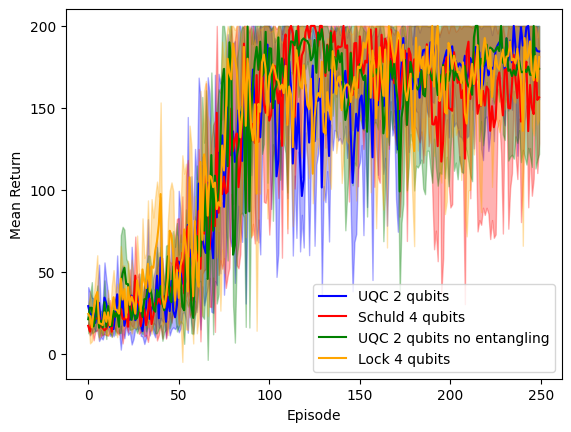

In [47]:
plt.plot(uqc_2qubits_training_mean_return,color = "blue", label = "UQC 2 qubits")
plt.plot(skolik_datareup_training_mean_return,color = "red", label = "Schuld 4 qubits")
plt.plot(uqc_2qubits_no_entangling_training_mean_return,color = "green", label = "UQC 2 qubits no entangling")
plt.plot(lock_datareup_training_mean_return,color = "orange", label = "Lock 4 qubits")
plt.fill_between(range(len(uqc_2qubits_training_mean_return)), uqc_2qubits_training_mean_return - uqc_2qubits_training_std_return, np.clip(uqc_2qubits_training_mean_return + uqc_2qubits_training_std_return, a_min = None, a_max = 200), alpha = 0.3, color = "blue")
plt.fill_between(range(len(skolik_datareup_training_mean_return)), skolik_datareup_training_mean_return - skolik_datareup_training_std_return, np.clip(skolik_datareup_training_mean_return + skolik_datareup_training_std_return, a_min = None, a_max = 200), alpha = 0.3, color = "red")
plt.fill_between(range(len(uqc_2qubits_no_entangling_training_mean_return)), uqc_2qubits_no_entangling_training_mean_return - uqc_2qubits_no_entangling_training_std_return, np.clip(uqc_2qubits_no_entangling_training_mean_return + uqc_2qubits_no_entangling_training_std_return, a_min = None, a_max = 200), alpha = 0.3, color = "green")
plt.fill_between(range(len(lock_datareup_training_mean_return)), lock_datareup_training_mean_return - lock_datareup_training_std_return, np.clip(lock_datareup_training_mean_return + lock_datareup_training_std_return, a_min = None, a_max = 200), alpha = 0.3, color = "orange")
plt.xlabel("Episode")
plt.ylabel("Mean Return")
plt.legend()
plt.show()

In [49]:
uqc_fullencoding_cz_weights = uqc_2qubits_training.get_weights_training()
uqc_fullencoding_nonentangling_weights = uqc_2qubits_no_entangling_training.get_weights_training()
skolik_weights = skolik_datareup_training.get_weights_training()
lock_weights = lock_datareup_training.get_weights_training()

In [50]:
for i in range(len(uqc_fullencoding_cz_weights)):
    for j in range(len(uqc_fullencoding_cz_weights[i])):
        uqc_fullencoding_cz_weights[i][j] = uqc_fullencoding_cz_weights[i][j][:-1]

for i in range(len(uqc_fullencoding_nonentangling_weights)):
    for j in range(len(uqc_fullencoding_nonentangling_weights[i])):
        uqc_fullencoding_nonentangling_weights[i][j] = uqc_fullencoding_nonentangling_weights[i][j][:-1]

for i in range(len(skolik_weights)):
    for j in range(len(skolik_weights[i])):
        skolik_weights[i][j] = skolik_weights[i][j][:-1]

for i in range(len(lock_weights)):
    for j in range(len(lock_weights[i])):
        lock_weights[i][j] = lock_weights[i][j][:-1]

In [51]:
num_layers = 5
num_qubits = 2

num_qubits_skolik = 4

for i in range(len(uqc_fullencoding_cz_weights)):
    for j in range(len(uqc_fullencoding_cz_weights[i])):
        uqc_fullencoding_cz_weights[i][j][0] = uqc_fullencoding_cz_weights[i][j][0].reshape(num_layers, num_qubits)

for i in range(len(uqc_fullencoding_nonentangling_weights)):
    for j in range(len(uqc_fullencoding_nonentangling_weights[i])):
        uqc_fullencoding_nonentangling_weights[i][j][0] = uqc_fullencoding_nonentangling_weights[i][j][0].reshape(num_layers, num_qubits)

for i in range(len(skolik_weights)):
    for j in range(len(skolik_weights[i])):
        skolik_weights[i][j][0] = skolik_weights[i][j][0].reshape(num_layers+1, num_qubits_skolik,2)
        skolik_weights[i][j][1] = skolik_weights[i][j][1].reshape(num_layers, num_qubits_skolik)

for i in range(len(lock_weights)):
    for j in range(len(lock_weights[i])):
        lock_weights[i][j][0] = lock_weights[i][j][0].reshape(num_layers+1, num_qubits_skolik,3)
        lock_weights[i][j][1] = lock_weights[i][j][1].reshape(num_layers, num_qubits_skolik)

In [52]:
def entangling_training(circuit, num_qubits, num_layers,params, entangling_layer, sample = 512):
    """
    Uses the weights of the PQC during training to calculate the entanglement capability of the PQC throughout the training process.
    To do that, it generates 512 random initial states and calculates the entanglement capability of the PQC with those states.
    """
    res = np.zeros((len(params),sample), dtype = complex)
    result = np.zeros(len(params), dtype = complex)

    for i in range(len(params)):
        for j in range(sample):
            data = np.random.uniform(low = -0.05, high = 0.05, size = 4)
            res[i][j] = q(circuit, params[i], num_qubits, num_layers, data, entangling_layer)
    
    for i in range(len(params)):
        result[i] = np.sum(res[i]).real/sample
    
    return result

In [55]:
dev_2qubits = qml.device("default.qubit", wires = 2)

uqc_2qubits_circuit = qml.QNode(uqc, dev_2qubits)

entangling_training_uqc_2qubits_cz_1 = entangling_training(uqc_2qubits_circuit, 2, 5, uqc_fullencoding_cz_weights[1], skolik_entangling_layer, sample = 4)
entangling_training_uqc_2qubits_cz_0 = entangling_training(uqc_2qubits_circuit, 2, 5, uqc_fullencoding_cz_weights[0], skolik_entangling_layer, sample = 4)
entangling_training_uqc_2qubits_cz_2 = entangling_training(uqc_2qubits_circuit, 2, 5, uqc_fullencoding_cz_weights[2], skolik_entangling_layer, sample = 4)
entangling_training_uqc_2qubits_cz_3 = entangling_training(uqc_2qubits_circuit, 2, 5, uqc_fullencoding_cz_weights[3], skolik_entangling_layer, sample = 4)
entangling_training_uqc_2qubits_cz_4 = entangling_training(uqc_2qubits_circuit, 2, 5, uqc_fullencoding_cz_weights[4], skolik_entangling_layer, sample = 4)

entangling_training_uqc_2qubits_no_entangling_0 = entangling_training(uqc_2qubits_circuit, 2, 5, uqc_fullencoding_nonentangling_weights[0], None, sample = 4)
entangling_training_uqc_2qubits_no_entangling_1 = entangling_training(uqc_2qubits_circuit, 2, 5, uqc_fullencoding_nonentangling_weights[1], None, sample = 4)
entangling_training_uqc_2qubits_no_entangling_2 = entangling_training(uqc_2qubits_circuit, 2, 5, uqc_fullencoding_nonentangling_weights[2], None, sample = 4)
entangling_training_uqc_2qubits_no_entangling_3 = entangling_training(uqc_2qubits_circuit, 2, 5, uqc_fullencoding_nonentangling_weights[3], None, sample = 4)
entangling_training_uqc_2qubits_no_entangling_4 = entangling_training(uqc_2qubits_circuit, 2, 5, uqc_fullencoding_nonentangling_weights[4], None, sample = 4)

entangling_training_skolik_0 = entangling_training(skolik_datareup_circuit, 4, 5, skolik_weights[0], skolik_entangling_layer, sample = 4)
entangling_training_skolik_1 = entangling_training(skolik_datareup_circuit, 4, 5, skolik_weights[1], skolik_entangling_layer, sample = 4)
entangling_training_skolik_2 = entangling_training(skolik_datareup_circuit, 4, 5, skolik_weights[2], skolik_entangling_layer, sample = 4)
entangling_training_skolik_3 = entangling_training(skolik_datareup_circuit, 4, 5, skolik_weights[3], skolik_entangling_layer, sample = 4)
entangling_training_skolik_4 = entangling_training(skolik_datareup_circuit, 4, 5, skolik_weights[4], skolik_entangling_layer, sample = 4)

entangling_training_lock_0 = entangling_training(lock_datareup_circuit, 4, 5, lock_weights[0], lock_entangling_layer, sample = 4)
entangling_training_lock_1 = entangling_training(lock_datareup_circuit, 4, 5, lock_weights[1], lock_entangling_layer, sample = 4)
entangling_training_lock_2 = entangling_training(lock_datareup_circuit, 4, 5, lock_weights[2], lock_entangling_layer, sample = 4)
entangling_training_lock_3 = entangling_training(lock_datareup_circuit, 4, 5, lock_weights[3], lock_entangling_layer, sample = 4)
entangling_training_lock_4 = entangling_training(lock_datareup_circuit, 4, 5, lock_weights[4], lock_entangling_layer, sample = 4)

/home/rodrigo/miniconda3/envs/pennylane/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


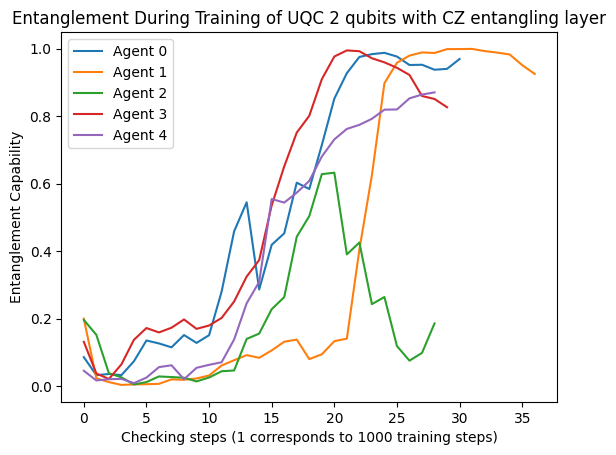

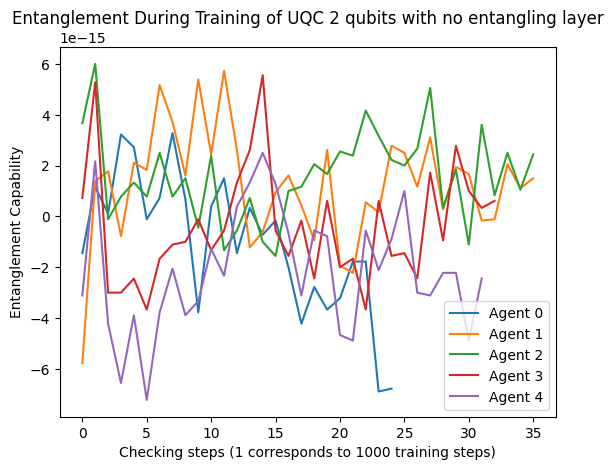

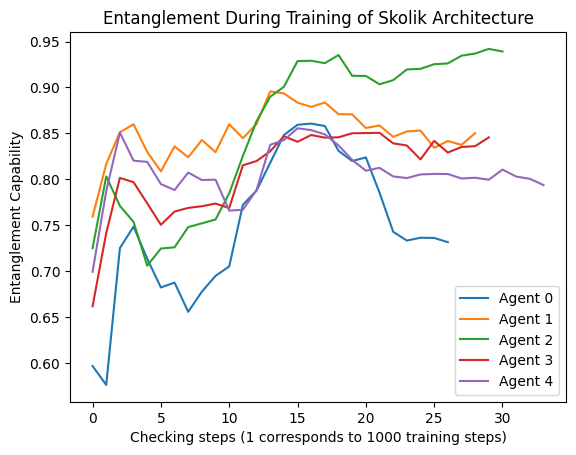

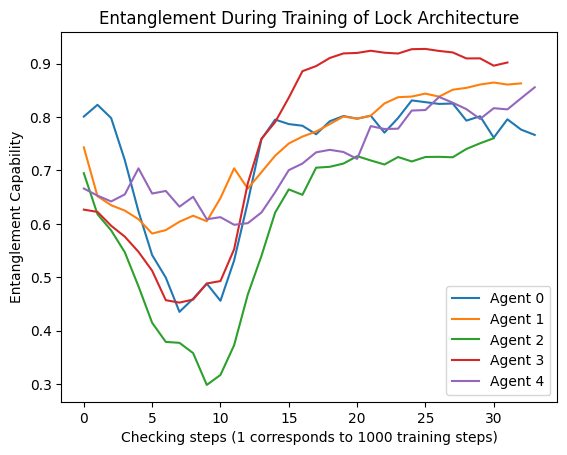

In [57]:



plt.plot(entangling_training_uqc_2qubits_cz_0, label = "Agent 0")
plt.plot(entangling_training_uqc_2qubits_cz_1, label = "Agent 1")
plt.plot(entangling_training_uqc_2qubits_cz_2, label = "Agent 2")
plt.plot(entangling_training_uqc_2qubits_cz_3, label = "Agent 3")
plt.plot(entangling_training_uqc_2qubits_cz_4, label = "Agent 4")
plt.xlabel("Checking steps (1 corresponds to 1000 training steps)")
plt.ylabel("Entanglement Capability")
plt.title("Entanglement During Training of UQC 2 qubits with CZ entangling layer")
plt.legend()
plt.show()

plt.plot(entangling_training_uqc_2qubits_no_entangling_0, label = "Agent 0")
plt.plot(entangling_training_uqc_2qubits_no_entangling_1, label = "Agent 1")
plt.plot(entangling_training_uqc_2qubits_no_entangling_2, label = "Agent 2")
plt.plot(entangling_training_uqc_2qubits_no_entangling_3, label = "Agent 3")
plt.plot(entangling_training_uqc_2qubits_no_entangling_4, label = "Agent 4")
plt.xlabel("Checking steps (1 corresponds to 1000 training steps)")
plt.ylabel("Entanglement Capability")
plt.title("Entanglement During Training of UQC 2 qubits with no entangling layer")
plt.legend()
plt.show()

plt.plot(entangling_training_skolik_0, label = "Agent 0")
plt.plot(entangling_training_skolik_1, label = "Agent 1")
plt.plot(entangling_training_skolik_2, label = "Agent 2")
plt.plot(entangling_training_skolik_3, label = "Agent 3")
plt.plot(entangling_training_skolik_4, label = "Agent 4")
plt.xlabel("Checking steps (1 corresponds to 1000 training steps)")
plt.ylabel("Entanglement Capability")
plt.title("Entanglement During Training of Skolik Architecture")
plt.legend()
plt.show()

plt.plot(entangling_training_lock_0, label = "Agent 0")
plt.plot(entangling_training_lock_1, label = "Agent 1")
plt.plot(entangling_training_lock_2, label = "Agent 2")
plt.plot(entangling_training_lock_3, label = "Agent 3")
plt.plot(entangling_training_lock_4, label = "Agent 4")
plt.xlabel("Checking steps (1 corresponds to 1000 training steps)")
plt.ylabel("Entanglement Capability")
plt.title("Entanglement During Training of Lock Architecture")
plt.legend()
plt.show()


In [60]:
entangling_training_skolik = np.array([entangling_training_skolik_0, entangling_training_skolik_1, entangling_training_skolik_2, entangling_training_skolik_3, entangling_training_skolik_4])
entangling_training_lock = np.array([entangling_training_lock_0, entangling_training_lock_1, entangling_training_lock_2, entangling_training_lock_3, entangling_training_lock_4])
entangling_training_uqc_2qubits_cz = np.array([entangling_training_uqc_2qubits_cz_0, entangling_training_uqc_2qubits_cz_1, entangling_training_uqc_2qubits_cz_2, entangling_training_uqc_2qubits_cz_3, entangling_training_uqc_2qubits_cz_4])
entangling_training_uqc_2qubits_no_entangling = np.array([entangling_training_uqc_2qubits_no_entangling_0, entangling_training_uqc_2qubits_no_entangling_1, entangling_training_uqc_2qubits_no_entangling_2, entangling_training_uqc_2qubits_no_entangling_3, entangling_training_uqc_2qubits_no_entangling_4])

/home/rodrigo/miniconda3/envs/pennylane/lib/python3.11/site-packages/autograd/numpy/numpy_wrapper.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return _np.array(args, *array_args, **array_kwargs)


(27,)